# Lab 7 - Triangulação em sistemas calibrados
Neste laboratório, vamos aprender a realizar a triangulação dos pontos, ou seja, recuperar a informação de profundidade dos pixels. Para isso, é necessário pelo menos dois pontos de vista de um mesmo ponto, assim como visto na Aula 7. Esse sistema de câmeras devem estar calibrados, ou seja, com suas matrizes K, dist, R e t já estimadas.

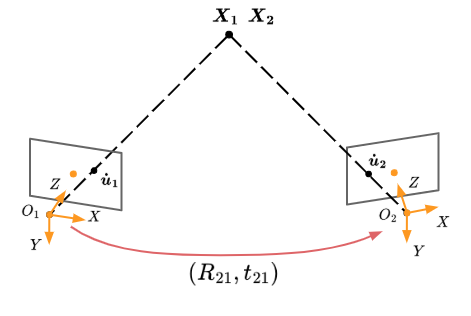

Veremos, no laboratório 8, que conseguimos descobrir a distância que um ArUco está da câmera utilizando apenas uma câmera. Entretanto, isso só é possível pelo fato de termos informações extras do ArUco, como, seu formato e dimensões métricas.

## Triangulação

In [ ]:
import numpy as np
from math import pi,cos,sin                  # Funções e variáveis matemáticas

###Definição de funções e objeto da câmera

In [ ]:
def translacao(dx):
  T = np.eye(len(dx)+1)
  for i, d in enumerate(dx):
    T[i,-1] = d
  return T

def rotacao(angulo,dim='2d'):
  anguloD = angulo*pi/180
  if dim == '2d':
    R = np.array([[cos(anguloD),-sin(anguloD),0],[sin(anguloD),cos(anguloD),0],[0,0,1]])
  elif dim == 'x':
    R = np.array([[1,0,0,0],[0,cos(anguloD),-sin(anguloD),0],[0,sin(anguloD),cos(anguloD),0],[0,0,0,1]])
  elif dim == 'y':
    R = np.array([[cos(anguloD),0,sin(anguloD),0],[0,1,0,0],[-sin(anguloD),0,cos(anguloD),0],[0,0,0,1]])
  else:
    R = np.array([[cos(anguloD),-sin(anguloD),0,0],[sin(anguloD),cos(anguloD),0,0],[0,0,1,0],[0,0,0,1]])
  return R

In [ ]:
class Camera(object):
  # cam = Camera(cam_pos=np.array([15,5,5]),cam_rot=np.array([-90,0,90]))
  def __init__(self,focal=1,cam_center=np.array([0,0]),cam_pos=np.array([0,0,0]),cam_rot=np.array([0,0,0])):
  # P = K[R|t]
    self.K = np.array([[focal,0,cam_center[0]],[0,focal,cam_center[1]],[0,0,1]])
    self.R = rotacao(cam_rot[2],dim='z')@rotacao(cam_rot[1],dim='y')@rotacao(cam_rot[0],dim='x')
    self.t = translacao(cam_pos)

    # Rt leva do que a camera ve para o mundo. inv(Rt) leva das coordenadas do mundo pras da camera
    self.Rt = np.linalg.inv(self.t@self.R)
    self.P = self.K@np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])@self.Rt

### Maneira 1 de triangulação: equações

A primeira forma de realizar a triangulação segue as soluções da esquação $z_2\boldsymbol{\dot{u}_2} = K_2\left ( z_1 R_{21} K_1^{-1} \boldsymbol{\dot{u}_1} + t_{21} \right )$ .

Em que:

$z_1' = \frac{t_x - x_{u2}t_z}{x_{u2}r_{zu1} - r_{xu1}}$, $z_1'' = \frac{t_y - y_{u2}t_z}{y_{u2}r_{zu1} - r_{yu1}}$ e $z_2 = z_1r_{zu1}+t_z$ .

In [ ]:
# Criação das câmeras
cam1 = Camera(focal=500,cam_center=np.array([319.5,239.5]))
cam2 = Camera(focal=500,cam_center=np.array([319.5,239.5]),cam_pos = np.array([10,-1,0]),cam_rot=np.array([0,-10,0]))

# Definição das matrizes
Rt21 = cam2.Rt
K1 = cam1.K
K2 = cam2.K

# u1 e u2 do Exemplo 1 da aula 7 para X1 = [1, 2, 5]^T
u1 = np.array([[419.5],[439.5],[1]])
u2 = np.array([[-296.747],[470.736],[1]])

Eu encontrei esses pixels projetando o ponto $\mathbf{X_1} = [1,2,5]^T$ nos planos da imagem da câmera 1 e câmera 2:

In [ ]:
# Ponto X1
X1 = np.array([[1],[2],[5]])

# Projecao de X1 na camera 1
u1 = K1@X1                        # Projeção na cam1
u1 = u1/u1[2]
print("u1:",u1)

# Projecao de X1 na camera 2, saindo do referencial 1 para o 2
X1h = np.vstack((X1,np.ones(1)))
X2h = Rt21@X1h                    # Mudança de referencial de cam1 para cam2
X2 = X2h[:-1]
u2 = K2@X2                        # Projeção na cam2
u2 = u2/u2[2]
print("u2:",u2)

u1: [[419.5]
 [439.5]
 [  1. ]]
u2: [[-296.74681665]
 [ 470.73624388]
 [   1.        ]]


Vamos utilizar aquelas equações acima para encontrar os dois valores possíveis de $z_1$ e $z_2$ e depois encontraremos $\mathbf{X_1}$:

In [ ]:
# Triangulação para encontrar z1 e z2
#u1 = np.array([[420],[440],[1]])
#u2 = np.array([[-297],[471],[1]])
xu1 = np.linalg.inv(K1)@u1
xu2 = np.linalg.inv(K2)@u2

# Definindo as matrizes R21 e t21
R21 = Rt21[:-1,:-1]
t21 = Rt21[:-1,-1].reshape(-1, 1)
rxu1 = R21@xu1

z1_1 = (t21[0]-xu2[0]*t21[2])/(xu2[0]*rxu1[2]-rxu1[0])
print("z1_1:",z1_1)
z1_2 = (t21[1]-xu2[1]*t21[2])/(xu2[1]*rxu1[2]-rxu1[1])
print("z1_2:",z1_2)
z2_1 = z1_1*rxu1[2]+t21[2]
print("z2_1:",z2_1)
z2_2 = z1_2*rxu1[2]+t21[2]
print("z2_2:",z2_2)
X1_calc = z1_1*np.linalg.inv(K1)@u1
print("X1:",X1_calc)
X1_calc = z1_2*np.linalg.inv(K1)@u1
print("X1:",X1_calc)

z1_1: [5.]
z1_2: [5.]
z2_1: [6.48687236]
z2_2: [6.48687236]
X1: [[1.]
 [2.]
 [5.]]
X1: [[1.]
 [2.]
 [5.]]


### Maneira 2 de triangulação: SVD

A segunda forma de realizar a triangulação vem da solução pelo SVD da matriz A:

$\underset{A}{\underbrace{\begin{bmatrix}
P_1 & -\boldsymbol{\dot{u}_1} & \boldsymbol{0} \\
P_2 & \boldsymbol{0} & -\boldsymbol{\dot{u}_2} \\
\end{bmatrix}}}\begin{bmatrix}
\boldsymbol{\dot{X}_1} \\
z_1 \\
z_2\end{bmatrix} = 0$ .

Em que a última linha de $\boldsymbol{v_N} = V^T[-1,:]$ deve estar no formato:

$\boldsymbol{v_N} = \lambda\begin{bmatrix}
x_1 \\
y_1 \\
z_1 \\
1 \\
z_1 \\
z_2\end{bmatrix}$ .

Ao dividir todos os elementos de $\boldsymbol{v_N}$ pelo elemento $\boldsymbol{{v_N}}[3]$, o fator $\lambda$ some e conseguimos estimar o ponto 3D $\boldsymbol{X_1}$.

In [ ]:
# Criação das câmeras
cam1 = Camera(focal=500,cam_center=np.array([319.5,239.5]))
cam2 = Camera(focal=500,cam_center=np.array([319.5,239.5]),cam_pos = np.array([10,-1,0]),cam_rot=np.array([0,-10,0]))

# Definição das matrizes
P11 = cam1.P
P21 = cam2.P

# u1 e u2 do Exemplo 1 da aula 7 para X1 = [1, 2, 5]^T
u1 = np.array([[419.5],[439.5],[1]])
u2 = np.array([[-296.747],[470.736],[1]])

# A[X1;z1;z2] = 0
A = np.vstack((np.hstack((P11,-u1,np.zeros((3,1)))),np.hstack((P21,np.zeros((3,1)),-u2))))

# Calcula o SVD(A) = U.S.Vt
U,S,Vt = np.linalg.svd(A)

# Reshape da ultima linha de Vt (ultima coluna de V) para a matriz de homografia
vN = Vt[-1,:].reshape(6,1)
vN = vN/vN[3]
print(vN)

[[0.99999825]
 [1.99999789]
 [4.99999854]
 [1.        ]
 [4.9999968 ]
 [6.48687291]]


In [ ]:
import cv2
X_hom = cv2.triangulatePoints(P11, P21, u1[:2], u2[:2])
X = X_hom / X_hom[3]
print(X)

[[0.99999955]
 [1.99999782]
 [4.99999856]
 [1.        ]]
